In [1]:
from typing import Sequence, Union
import os
from tqdm import tqdm
import joblib

import numpy as np
import pandas as pd
import xarray as xr
from scipy import linalg

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import torch

import src
from src.attrs import PATHS, GLOBALS
from src import utils

from src.data import loading
from src.train import datasets, losses
from src.models import base, koopman_autoencoder, cnn
from src.tools import plot

~/.conda/envs/koopman/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
SUBPROJECT = 'cnn_pacific_daily_subsampled'

# Configs
plt.style.use('custom.mplstyle')
torch.set_grad_enabled(False);
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
# Data
MAX_SAMPLES = 50_000
X_test = xr.open_dataarray(os.path.join(PATHS[SUBPROJECT], 'X_8.nc'))
X_test = X_test[0:MAX_SAMPLES, 0:1, ...]
X_test = torch.from_numpy(X_test.values)
weights = torch.load(os.path.join(PATHS[SUBPROJECT], 'weights.pt'))
mask = xr.open_dataarray(os.path.join(PATHS[SUBPROJECT], 'mask.nc'))
areas = xr.open_dataarray(os.path.join(PATHS['grid'], 'areas.nc'))

In [4]:
def weighted_mse(X_true, X_pred, weights):
    mse = torch.mean(
        torch.sum(weights**2 * (X_pred - X_test)**2, dim=(2,3)) / weights.sum(),
        dim=0
    )
    return mse.item()

---

In [5]:
D_list = [10, 20, 30, 40]

mse = xr.DataArray(
    np.empty((4,3)),
    dims=('D', 'model'),
    coords={'D': D_list, 'model': ['PCA', 'CAE', 'KAE']}
)

for j, D in enumerate(D_list):
    # Load models
    pca = joblib.load(os.path.join(PATHS[SUBPROJECT], 'pca', f'pca_ssh_{D}.joblib'))
    cae = base.load_model_from_yaml(os.path.join(PATHS[SUBPROJECT], 'cae', f'cae_ssh.{D}'))
    kae = base.load_model_from_yaml(os.path.join(PATHS[SUBPROJECT], 'kae', f'kae_ssh.{D}'))
    cae = cae.to(DEVICE);
    kae = kae.to(DEVICE);
    
    # PCA MSE
    X_shape = X_test.shape
    X_weighted = X_test * weights
    X_weighted = X_weighted.view(X_weighted.shape[0], -1)
    z = pca.transform(X_weighted)
    X_pred = pca.inverse_transform(z)
    X_pred = torch.from_numpy(X_pred)
    X_pred = X_pred.view(*X_shape)
    X_pred = X_pred / weights
    X_pred = torch.where(weights != 0, X_pred, 0)
    mse[j, 0] = weighted_mse(X_test, X_pred, weights)

    # CAE MSE
    weights.to(DEVICE)
    X_pred = torch.zeros_like(X_test)
    for i, sample in enumerate(tqdm(X_test)):
        sample = sample.to(DEVICE)
        sample = sample.view(1, *sample.shape)
        X_pred[i, :] = cae(sample)
    mse[j, 1] = weighted_mse(X_test, X_pred, weights)

    # KAE MSE
    X_pred = torch.zeros_like(X_test)
    for i, sample in enumerate(tqdm(X_test)):
        sample = sample.to(DEVICE)
        sample = sample.view(1, *sample.shape)
        X_pred[i, :] = kae.autoencoder(sample)
    mse[j, 2] = weighted_mse(X_test, X_pred, weights)

100%|██████████| 50000/50000 [01:08<00:00, 728.31it/s]


In [24]:
mse

<xarray.DataArray (D: 4, model: 3)>
array([[0.29578996, 0.29063189, 0.30173066],
       [0.18222303, 0.1778716 , 0.18990527],
       [0.13084825, 0.12642193, 0.14314584],
       [0.1006729 , 0.09894365, 0.11401457]])
Coordinates:
  * D        (D) int64 10 20 30 40
  * model    (model) <U3 'PCA' 'CAE' 'KAE'

In [6]:
D_list = [10, 20, 30, 40]

mse_data = np.array([
    [0.29578996, 0.29063189, 0.30173066],
    [0.18222303, 0.1778716 , 0.18990527],
    [0.13084825, 0.12642193, 0.14314584],
    [0.1006729 , 0.09894365, 0.11401457]
])

mse = xr.DataArray(
    mse_data, 
    dims=('D', 'model'),
    coords={'D': D_list, 'model': ['PCA', 'CAE', 'KAE']}
)

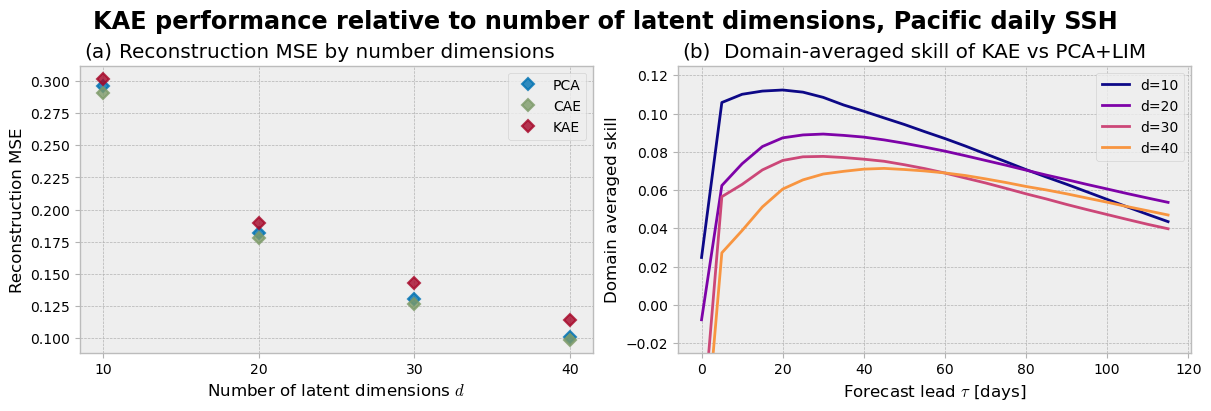

In [7]:
fig, axes = plt.subplot_mosaic(
    [['a', 'b']],
    figsize=(12,4),
    layout='constrained'
)

D_list = [10, 20, 30, 40]

###############################################################################
# Reconstruction error by number of dimensions
kwargs = dict(ls='', marker='D', alpha=0.8, markeredgewidth=1.5)

axes['a'].plot(D_list, mse[:, 0], label='PCA', color='C0', **kwargs)
axes['a'].plot(D_list, mse[:, 1], label='CAE', color='C3', **kwargs)
axes['a'].plot(D_list, mse[:, 2], label='KAE', color='C1', **kwargs)
axes['a'].set(
    xlabel=r'Number of latent dimensions $d$',
    ylabel='Reconstruction MSE',
    title='Reconstruction MSE by number dimensions',
    # ylim=(0,None)
    xticks=D_list
)
axes['a'].legend()

###############################################################################
# Prediction skill by number of dimensions
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(0, len(D_list))

metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
for i, D in enumerate(D_list):
    # mse_dp = xr.open_dataarray(os.path.join(metrics_path, f'dp_pca_ssh_d{D}_best_sample_mse.nc'))
    mse_lim = xr.open_dataarray(os.path.join(metrics_path, f'lim_pca_ssh_d{D}_best_sample_mse.nc'))
    mse_koopman = xr.open_dataarray(os.path.join(metrics_path, f'kae_ssh_d{D}_sample_mse.nc'))
    # SS_koopman_dp = (1 - mse_koopman / mse_dp).sel(variable='SSH')
    SS_koopman_lim = (1 - mse_koopman / mse_lim).sel(variable='SSH')

    # SS_koopman_dp.weighted(areas).mean(dim=('lat', 'lon')).plot(
    #     ax=axes['b'], ls=':', color=f'C{i}', label=f'D={D} Skill KAE vs DP'
    # )
    SS_koopman_lim.weighted(areas).mean(dim=('lat', 'lon')).plot(
        ax=axes['b'], ls='-', color=cmap(norm(i)), label=f'd={D}'
    )

axes['b'].set(
    title='Domain-averaged skill of KAE vs PCA+LIM',
    xlabel=r'Forecast lead $\tau$ [days]',
    ylabel='Domain averaged skill',
    ylim=(-0.025, 0.125)
)
axes['b'].legend()

for label, ax in axes.items():
    ax.annotate(
        f'({label})',
        xy=(0, 1), xycoords='axes fraction',
        xytext=(+0.2, +1.2), textcoords='offset fontsize',
        fontsize='x-large', verticalalignment='top',
    )

fig.suptitle("KAE performance relative to number of latent dimensions, Pacific daily SSH", fontsize='xx-large', )
plt.savefig(os.path.join(PATHS['visualization'], 'Figures', 'dimensionality.pdf'))

In [9]:
mse_clim = xr.open_dataarray(os.path.join(metrics_path, f'clim_sample_mse.nc')).sel(variable='SSH')

In [12]:
SS_koopman = (1 - mse_koopman / mse_clim).sel(variable='SSH')

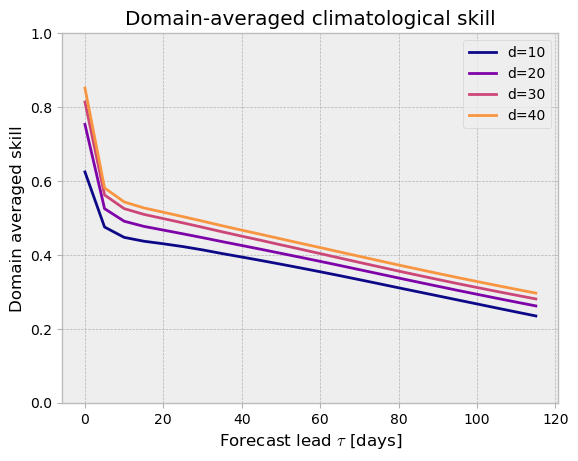

In [40]:
fig, ax = plt.subplots()

for i, D in enumerate(D_list):
    # mse_dp = xr.open_dataarray(os.path.join(metrics_path, f'dp_pca_ssh_d{D}_best_sample_mse.nc'))
    mse_lim = xr.open_dataarray(os.path.join(metrics_path, f'lim_pca_ssh_d{D}_best_sample_mse.nc'))
    mse_koopman = xr.open_dataarray(os.path.join(metrics_path, f'kae_ssh_d{D}_sample_mse.nc'))

    SS_koopman = (1 - mse_koopman / mse_clim).sel(variable='SSH')

    SS_koopman.weighted(areas).mean(dim=('lat', 'lon')).plot(
        ax=ax, ls='-', color=cmap(norm(i)), label=f'd={D}'
    )

ax.set(
    title='Domain-averaged climatological skill',
    xlabel=r'Forecast lead $\tau$ [days]',
    ylabel='Domain averaged skill',
    ylim=(0, 1)
)

ax.legend()

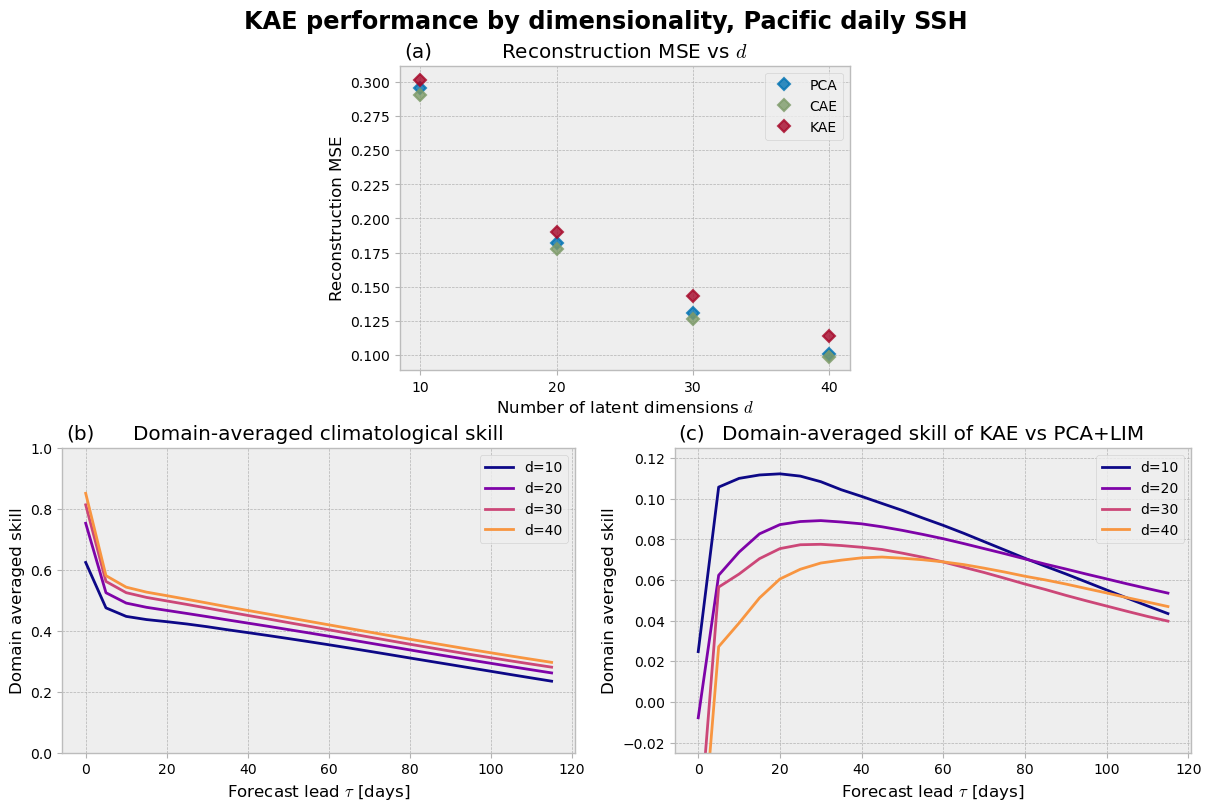

In [26]:
fig, axes = plt.subplot_mosaic(
    [['x', 'a', 'a', 'y'], ['b', 'b', 'c', 'c']],
    width_ratios=[1,0.75,0.75,1],
    height_ratios=[1,1],
    figsize=(12,8),
    layout='constrained'
)
fig.delaxes(axes['x'])
fig.delaxes(axes['y'])

D_list = [10, 20, 30, 40]

###############################################################################
# Reconstruction error by number of dimensions
kwargs = dict(ls='', marker='D', alpha=0.8, markeredgewidth=1.5)

axes['a'].plot(D_list, mse[:, 0], label='PCA', color='C0', **kwargs)
axes['a'].plot(D_list, mse[:, 1], label='CAE', color='C3', **kwargs)
axes['a'].plot(D_list, mse[:, 2], label='KAE', color='C1', **kwargs)

###############################################################################
# Prediction skill by number of dimensions
cmap = plt.get_cmap('plasma')
norm = plt.Normalize(0, len(D_list))

metrics_path = os.path.join(PATHS[SUBPROJECT], 'forecast_metrics')
mse_clim = xr.open_dataarray(
    os.path.join(metrics_path, f'clim_sample_mse.nc')
).sel(variable='SSH')

for i, D in enumerate(D_list):
    # MSE
    mse_lim = xr.open_dataarray(os.path.join(metrics_path, f'lim_pca_ssh_d{D}_best_sample_mse.nc'))
    mse_koopman = xr.open_dataarray(os.path.join(metrics_path, f'kae_ssh_d{D}_sample_mse.nc'))

    # Skill
    SS_koopman = (1 - mse_koopman / mse_clim).sel(variable='SSH')
    SS_koopman_lim = (1 - mse_koopman / mse_lim).sel(variable='SSH')

    # Domain averaged
    SS_koopman.weighted(areas).mean(dim=('lat', 'lon')).plot(
        ax=axes['b'], ls='-', color=cmap(norm(i)), label=f'd={D}'
    )
    SS_koopman_lim.weighted(areas).mean(dim=('lat', 'lon')).plot(
        ax=axes['c'], ls='-', color=cmap(norm(i)), label=f'd={D}'
    )

# Axis properties
axes['a'].set(
    xlabel=r'Number of latent dimensions $d$',
    ylabel='Reconstruction MSE',
    title=r'Reconstruction MSE vs $d$',
    # ylim=(0,None)
    xticks=D_list
)
axes['b'].set(
    title='Domain-averaged climatological skill',
    xlabel=r'Forecast lead $\tau$ [days]',
    ylabel='Domain averaged skill',
    ylim=(0, 1)
)
axes['c'].set(
    title='Domain-averaged skill of KAE vs PCA+LIM',
    xlabel=r'Forecast lead $\tau$ [days]',
    ylabel='Domain averaged skill',
    ylim=(-0.025, 0.125)
)
axes['a'].legend()
axes['b'].legend()
axes['c'].legend()

for label, ax in axes.items():
    if label in list('abc'):
        ax.annotate(
            f'({label})',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.2, +1.2), textcoords='offset fontsize',
            fontsize='x-large', verticalalignment='top',
        )

fig.suptitle("KAE performance by dimensionality, Pacific daily SSH", fontsize='xx-large', )
plt.savefig(os.path.join(PATHS['visualization'], 'Figures', 'dimensionality.pdf'))